<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_RPCA_with_prox_backward_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla P100-PCIE-16GB
0
0


# L1 and nuclear loss functions with backward by prox (soft thresholding and singular value thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

## L1 loss
class L1LossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        ctx.save_for_backward(input, lw)
        return torch.sum(torch.abs(input)*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw = ctx.saved_tensors
        grad_input = grad_output.clone()
        return (input - soft(input, lw)) * grad_input, torch.abs(input) * grad_input

class L1Loss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(L1Loss, self).__init__()
        self.fn = L1LossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


## Nuclear loss
class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input

class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Robust PCA (Low-rank and sparse matrix approximation): $$\textrm{Minimize}_{(L,S)}\|L\|_* + \lambda_S \|S\|_1+\lambda_F\|D-(L+S)\|_F^2$$
### Auto differentiation vs. proximal operation



In [0]:
# generate a low-rank matrix L and a sparse matrix S
from time import time
import numpy as np
m, n = 10000, 50
rnk, nnz = 10, 10000
LL = np.random.randn(m,rnk).dot(np.random.randn(rnk,n))
SS = np.zeros((m,n))
support = np.random.choice(m*n, nnz, replace=False)
SS.ravel()[support] = 10.* np.random.randn(support.size)

sv = np.linalg.svd(LL, compute_uv=False)
print('singular values of L =')
print(sv[:min(10,m,n)])
print('mean(abs(L)) = %.2e' % (np.mean(np.abs(LL))))
print('mean(abs(S)) = %.2e, %d nonzeros in S (%2.1f%%)' % (np.mean(np.abs(SS)),support.size,100.*support.size/(m*n)))

DD = LL + SS

ls = 1./np.sqrt(max(m,n))
print('lambda_S = ', ls)

singular values of L =
[948.41338822 884.25327543 802.17781935 712.4056368  691.10332653
 638.75476588 606.00447002 565.21250907 488.07011278 455.82901922]
mean(abs(L)) = 2.43e+00
mean(abs(S)) = 1.60e-01, 10000 nonzeros in S (2.0%)
lambda_S =  0.01


In [0]:
class dummyUnet(torch.nn.Module):
    def __init__(self, w=torch.tensor(1.0, device=device)):
        super(dummyUnet, self).__init__()
        self.param = torch.nn.Parameter(w, requires_grad=True)

    def forward(self, inputD):  # compute the output only from inputD!
        return self.param


## ADMM-type (Inexact ALM) application of backward by prox
### less estimation error, can clearly identify the sparse components

D = 
 tensor([[-1.9078, -7.7488,  1.6149,  ...,  0.9241, -0.6018,  1.0441],
        [ 2.3948,  1.0600,  3.6488,  ...,  1.2157,  2.8473,  2.5703],
        [-4.2848, -3.4934, -2.7512,  ...,  0.1583, -1.2561,  0.0852],
        ...,
        [ 2.3009, -4.9701, -5.0886,  ...,  9.2245, -4.1329, -4.1057],
        [-2.0504, -1.4911,  0.8353,  ..., -3.6806, -4.8151,  1.3233],
        [-3.3348, -1.8457, -0.9671,  ...,  2.3730, -6.6186,  0.1779]],
       device='cuda:0')
lambda_F =  1000000.0
[ 40/400]: loss = 11503.8838,  
[ 80/400]: loss = 10434.3955,  
[120/400]: loss = 9411.9609,  
[160/400]: loss = 8464.9053,  
[200/400]: loss = 7774.4429,  
[240/400]: loss = 7642.8853,  
[280/400]: loss = 7617.8018,  
[320/400]: loss = 7606.0176,  
[360/400]: loss = 7599.9292,  
[400/400]: loss = 7596.4146,  
8647.601842880249  [ms]
L = 
 [[-1.90784113 -7.74878444  1.61491485 ...  0.92411368 -0.60183474
   1.04409228]
 [ 2.39482888  1.06002676  3.64876465 ...  1.21573597  2.8473001
   2.57034605]
 [-4.284835

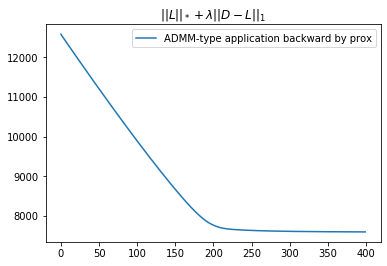

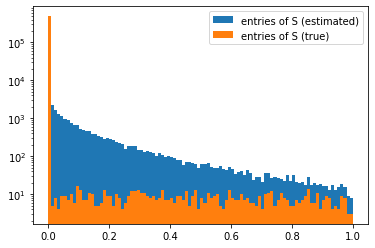

In [0]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6
print('lambda_F = ', le)

# Using L1Loss with prox
nucloss = NuclearLoss()
l1loss = L1Loss(lw=torch.tensor(ls))
l2loss = lambda x: torch.sum(x**2)

L = 0
S = 0
E = 0
Y = 0

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss_inexact = []
for iter in range(num_iter):
    total_loss = 0.

    X = (D-S-E+Y).clone().detach().requires_grad_(True)
    loss = nucloss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    L = X.detach()

    X = (D-L-E+Y).clone().detach().requires_grad_(True)
    loss = l1loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    S = X.detach()

    X = ((D-L-S+Y)/ (1+2*le)).clone().detach().requires_grad_(True)
    loss = l2loss(X)
    optimizer = torch.optim.SGD([X], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    E = X.detach()

    Y = Y + (D-L-S-E)

    total_loss = nucloss(L) + l1loss(D-L)

    history_loss_inexact.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

## ISTA with backward by prox
$$ L^{(k+1)}\gets\textrm{SVT}(L^{(k)}+\alpha(D-L^{(k)}-S^{(k)}),\alpha\lambda_L)$$
$$ S^{(k+1)}\gets\textrm{soft}(S^{(k)}+\alpha(D-L^{(k)}-S^{(k)}),\alpha\lambda_S)$$


D = 
 tensor([[-1.9078, -7.7488,  1.6149,  ...,  0.9241, -0.6018,  1.0441],
        [ 2.3948,  1.0600,  3.6488,  ...,  1.2157,  2.8473,  2.5703],
        [-4.2848, -3.4934, -2.7512,  ...,  0.1583, -1.2561,  0.0852],
        ...,
        [ 2.3009, -4.9701, -5.0886,  ...,  9.2245, -4.1329, -4.1057],
        [-2.0504, -1.4911,  0.8353,  ..., -3.6806, -4.8151,  1.3233],
        [-3.3348, -1.8457, -0.9671,  ...,  2.3730, -6.6186,  0.1779]],
       device='cuda:0')
[ 80/800]: loss = 11556.1043,  
[160/800]: loss = 10486.0916,  
[240/800]: loss = 9463.0465,  
[320/800]: loss = 8515.0701,  
[400/800]: loss = 7817.1689,  
[480/800]: loss = 7675.6509,  
[560/800]: loss = 7648.0435,  
[640/800]: loss = 7634.8557,  
[720/800]: loss = 7627.9900,  
[800/800]: loss = 7624.0065,  
9221.010208129883  [ms]
L = 
 [[-1.90784113 -7.74878444  1.61491485 ...  0.92411368 -0.60183474
   1.04409228]
 [ 2.39482888  1.06002676  3.64876465 ...  1.21573597  2.8473001
   2.57034605]
 [-4.28483543 -3.49340388 -2.7511

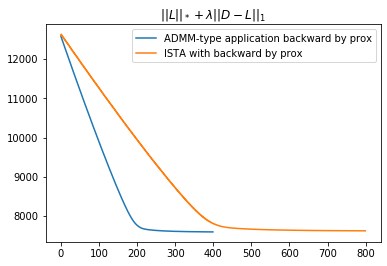

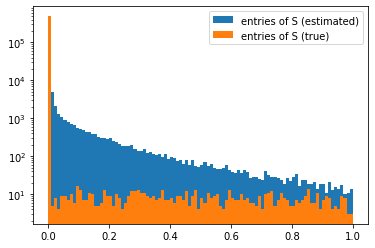

In [0]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

ln = 1.
alpha = 1.
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
l1loss = L1Loss(lw=torch.tensor(alpha*ls))
#X = torch.autograd.Variable(D, requires_grad=True)
L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(L, device=device, requires_grad=True)
#optimizer = torch.optim.SGD([L,S], lr = 1e0)

t = time()
num_iter = 800
display_step = num_iter // 10
history_loss_prox = []
for iter in range(num_iter):
    total_loss = 0.

    # E = (L + S + alpha * R.T.dot(D - R.dot(L + S))).detach()
    E = (L + S + alpha * (D - L - S)).detach()

    Lk = L.detach()
    L = (E-S).clone().detach().requires_grad_(True)
    loss = nucloss(L)
    optimizer = torch.optim.SGD([L], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()/alpha

    S = (E-Lk).clone().detach().requires_grad_(True)
    loss = l1loss(S)
    optimizer = torch.optim.SGD([S], lr = 1e0)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()/alpha
    #"""

    history_loss_prox.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n',L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA with backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

### Best practice: Adam followed by SGD

D = 
 tensor([[-1.9078, -7.7488,  1.6149,  ...,  0.9241, -0.6018,  1.0441],
        [ 2.3948,  1.0600,  3.6488,  ...,  1.2157,  2.8473,  2.5703],
        [-4.2848, -3.4934, -2.7512,  ...,  0.1583, -1.2561,  0.0852],
        ...,
        [ 2.3009, -4.9701, -5.0886,  ...,  9.2245, -4.1329, -4.1057],
        [-2.0504, -1.4911,  0.8353,  ..., -3.6806, -4.8151,  1.3233],
        [-3.3348, -1.8457, -0.9671,  ...,  2.3730, -6.6186,  0.1779]],
       device='cuda:0')
[ 10/100]: loss = 11265.5771,  
[ 20/100]: loss = 9203.7207,  
[ 30/100]: loss = 8658.0137,  
[ 40/100]: loss = 8401.0020,  
[ 50/100]: loss = 8291.2607,  
[ 60/100]: loss = 8240.5977,  
[ 70/100]: loss = 8215.6758,  
[ 80/100]: loss = 8201.4209,  
[ 90/100]: loss = 8191.4131,  
[100/100]: loss = 8184.2969,  
[ 60/600]: loss = 7666.3894,  
[120/600]: loss = 7634.9919,  
[180/600]: loss = 7621.8963,  
[240/600]: loss = 7614.1964,  
[300/600]: loss = 7609.7657,  
[360/600]: loss = 7607.2249,  
[420/600]: loss = 7605.5828,  
[480/600

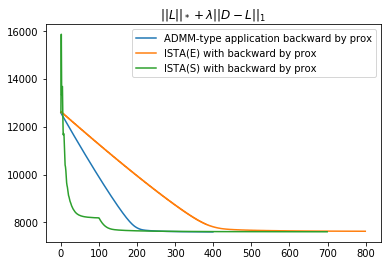

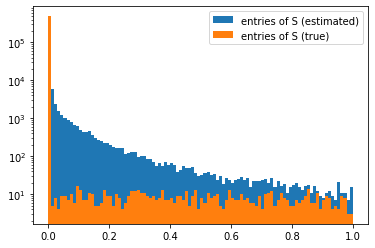

In [0]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

#model = dummyUnet()
model = dummyUnet(w=torch.zeros_like(D, device=device, requires_grad=True))
optimizerM = torch.optim.Adam(model.parameters(), lr = 1e0)


ln = 1.
alpha = 0.5
# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(alpha*ln))
l1loss = L1Loss(lw=torch.tensor(alpha*ls))

anucloss = lambda x: torch.sum(torch.svd(x)[1])*alpha*ln
al1loss = lambda x: torch.sum(torch.abs(x)*alpha*ls)

#X = torch.autograd.Variable(D, requires_grad=True)
#S = torch.zeros_like(D, device=device, requires_grad=True)
S = model(D)


t = time()
num_iter = 100
display_step = num_iter // 10
history_loss_prox_ISTA = []
#optimizer = torch.optim.Adam([S], lr = 1e0)
for iter in range(num_iter):

    total_loss = 0.
    loss = anucloss(D-S) + al1loss(S)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    history_loss_prox_ISTA.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


num_iter = 600
display_step = num_iter // 10
#history_loss_prox_ISTA = []
#L = D.clone().detach()
#optimizer = torch.optim.SGD([S], lr = 1e0)
optimizerM = torch.optim.SGD(model.parameters(), lr = 1e0)
for iter in range(num_iter):

    total_loss = 0.
    #Lk = L.detach()
    with torch.no_grad():
        Sk = model(D).detach()
    Lk = (D-Sk).detach()
    S = model(D)
    #L = Lk + alpha * (D - Lk -S)
    #L = Lk + alpha * (Sk - S)
    #loss = nucloss(L)
    loss = nucloss(Lk + alpha * (Sk - S))
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha

    #St = S + alpha * (D - Lk - S)
    #loss = l1loss(St)
    #loss = l1loss(S + alpha * (D - Lk - S))
    loss = l1loss(S + alpha * (Sk - S))
    #optimizer = torch.optim.SGD([W], lr = 1e0)
    optimizerM.zero_grad()
    loss.backward(retain_graph=True)
    optimizerM.step()
    total_loss += loss.item() / alpha
    #"""

    history_loss_prox_ISTA.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n',L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
#S = D-L
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

## RPCA with alternating gradient descent using autograd
### cannot sparsify the solution due to the nondifferentiability (see the estimated S), although decrease the loss faster

D = 
 tensor([[-1.9078, -7.7488,  1.6149,  ...,  0.9241, -0.6018,  1.0441],
        [ 2.3948,  1.0600,  3.6488,  ...,  1.2157,  2.8473,  2.5703],
        [-4.2848, -3.4934, -2.7512,  ...,  0.1583, -1.2561,  0.0852],
        ...,
        [ 2.3009, -4.9701, -5.0886,  ...,  9.2245, -4.1329, -4.1057],
        [-2.0504, -1.4911,  0.8353,  ..., -3.6806, -4.8151,  1.3233],
        [-3.3348, -1.8457, -0.9671,  ...,  2.3730, -6.6186,  0.1779]],
       device='cuda:0')
[ 40/400]: loss = 8616.1836,  
[ 80/400]: loss = 8574.8728,  
[120/400]: loss = 8567.8357,  
[160/400]: loss = 8566.6306,  
[200/400]: loss = 8566.2358,  
[240/400]: loss = 8565.1799,  
[280/400]: loss = 8565.8677,  
[320/400]: loss = 8563.5602,  
[360/400]: loss = 8562.4485,  
[400/400]: loss = 8562.9512,  
4504.583120346069  [ms]
L = 
 [[-1.90784113 -7.74878444  1.61491485 ...  0.92411368 -0.60183474
   1.04409228]
 [ 2.39482888  1.06002676  3.64876465 ...  1.21573597  2.8473001
   2.57034605]
 [-4.28483543 -3.49340388 -2.751163

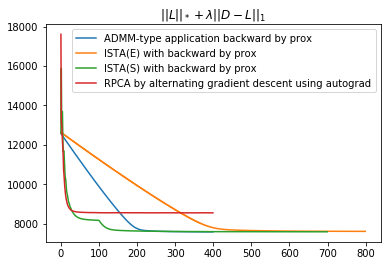

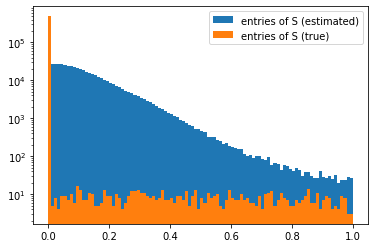

In [0]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ls)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
optimizer = torch.optim.Adam([L], lr = 1e0)

t = time()
num_iter = 400
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    """
    loss = nucloss(L) + l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    loss = l1loss(D-L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    #"""

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))


print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
S = D-L
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by alternating gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

## RPCA by gradient descent using autograd
### straightforward use of autograd for RPCA cannot sparsify the solution (see the estimated S).

D = 
 tensor([[-1.9078, -7.7488,  1.6149,  ...,  0.9241, -0.6018,  1.0441],
        [ 2.3948,  1.0600,  3.6488,  ...,  1.2157,  2.8473,  2.5703],
        [-4.2848, -3.4934, -2.7512,  ...,  0.1583, -1.2561,  0.0852],
        ...,
        [ 2.3009, -4.9701, -5.0886,  ...,  9.2245, -4.1329, -4.1057],
        [-2.0504, -1.4911,  0.8353,  ..., -3.6806, -4.8151,  1.3233],
        [-3.3348, -1.8457, -0.9671,  ...,  2.3730, -6.6186,  0.1779]],
       device='cuda:0')
[ 80/800]: loss = 8914.5732,  
[160/800]: loss = 8915.2861,  
[240/800]: loss = 8923.0889,  
[320/800]: loss = 8931.0225,  
[400/800]: loss = 8933.9199,  
[480/800]: loss = 8938.7930,  
[560/800]: loss = 8938.7959,  
[640/800]: loss = 8941.6592,  
[720/800]: loss = 8945.2441,  
[800/800]: loss = 8943.6416,  
8765.326738357544  [ms]
L = 
 [[-1.90784113 -7.74878444  1.61491485 ...  0.92411368 -0.60183474
   1.04409228]
 [ 2.39482888  1.06002676  3.64876465 ...  1.21573597  2.8473001
   2.57034605]
 [-4.28483543 -3.49340388 -2.751163

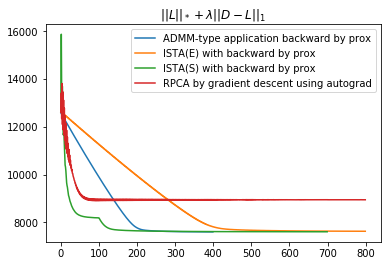

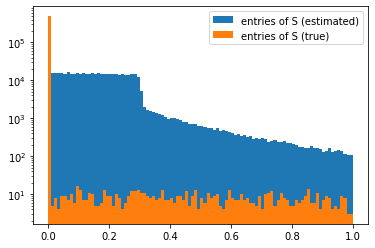

In [0]:
D = torch.from_numpy(DD.astype(np.float32)).to(device)
print('D = \n', D)

le = 1e+6

# Using sum of abs with autogradient
nucloss = lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x)*ls)
l2loss = lambda x: torch.sum(x**2)

L = torch.tensor(DD.astype(np.float32), device=device, requires_grad=True)
S = torch.zeros_like(D, device=device, requires_grad=True)

t = time()
num_iter = 800
display_step = num_iter // 10
history_loss = []
for iter in range(num_iter):
    total_loss = 0.
    #"""
    #optimizer = torch.optim.SGD([L,S], lr = 1e0)
    #loss = nucloss(L) + l1loss(S) + l2loss((D-L-S)/(1+2*le))

    #optimizer = torch.optim.SGD([L], lr = 1e0)   # SGD works better than Adam
    optimizer = torch.optim.AdamW([L], lr = 0.3)  # Adam would disappoint you
    loss = nucloss(L) + l1loss(D-L)

    #optimizer = torch.optim.SGD([S], lr = 1e0)   # SGD works better than Adam
    #optimizer = torch.optim.Adam([S], lr = 1e-1)  # Adam would disappoint you
    #loss = nucloss(D-S) + l1loss(S)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """
    optimizer = torch.optim.SGD([L], lr = 1e-1)
    loss = nucloss(L)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([S], lr = 1e-1)
    loss = l1loss(S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()

    optimizer = torch.optim.SGD([L,S], lr = 1e-1)
    loss = l2loss(D-L-S)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    total_loss += loss.item()
    """

    #total_loss = nucloss(L) + l1loss(D-L)
    history_loss.append(total_loss)

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, total_loss))

S = D-L
#L = D-S

print((time()-t)*1000, ' [ms]')
print('L = \n', LL)
print('Estimated L = \n', L.data)
print('MSE of L: ', np.linalg.norm(L.cpu().data.numpy()-LL)/np.linalg.norm(LL)*100, ' [%]')
print('Its singular values = \n', torch.svd(L)[1])
print('S = \n', SS)
print('Estimated S = \n', S.data)
print("MSE of S: ", np.linalg.norm(S.cpu().data.numpy()-SS)/np.linalg.norm(SS)*100, " [%]")

import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.legend()
plt.figure()
plt.hist(abs(S.cpu().data.numpy().ravel()), bins=100, range=[0,1], log=True, label='entries of S (estimated)')
plt.hist(abs(SS.ravel()), bins=100, range=[0,1], log=True, label='entries of S (true)')
plt.legend()

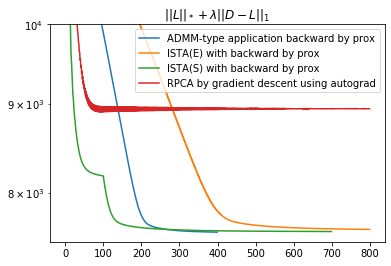

In [0]:
import matplotlib.pyplot as plt
plt.title("$||L||_*+\lambda||D-L||_1$")
plt.plot(history_loss_inexact, label="ADMM-type application backward by prox")
#plt.plot(history_loss_prox, label="RPCA with backward by prox")
plt.plot(history_loss_prox, label="ISTA(E) with backward by prox")
plt.plot(history_loss_prox_ISTA, label="ISTA(S) with backward by prox")
plt.plot(history_loss, label="RPCA by gradient descent using autograd")
plt.yscale('log'); plt.ylim(7.5e+3,1e+4)
plt.legend()
